# Dynamics of Software Development and Archiving

### Import libraries

In [1]:
import json

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from tqdm import tqdm

### Download data

In [2]:
df = pd.read_csv('../data/articles_swhinfo.tsv', sep='\t')

### Create a file with te dataset statistics

In [4]:
with open("../data/data_stat.txt", "w") as f:
    f.write(f"Total number of articles in PubMed with 'github.com' query : {len(df)}\n")
    df.dropna(subset=['PubDate'], inplace=True)
    f.write(f"Articles after removing the ones without the publication date : {len(df)}\n")
    df['PubDate'] = pd.to_datetime(df['PubDate'])
    df = df[df['PubDate'].dt.year != 2023]
    f.write(f"Articles after removing the ones published in 2023 : {len(df)}\n")
    df.dropna(subset=['GitHub_owner'], inplace=True)
    f.write(f"Articles after removing the ones without GitHub link : {len(df)}\n")
    df.dropna(subset=['GitHub_repo'], inplace=True)
    f.write(f"Articles after removing the ones with the wrong GitHub link (no repository name) : {len(df)}\n")
    df = df[df['Fork'] == 0]
    f.write(f"Articles after removing the GitHub forks : {len(df)}\n")
    df.dropna(subset=['Repo_created_at'], inplace=True)
    f.write(f"Articles after removing the ones with the repository deleted or wrong link (unable to access with GitHub API): {len(df)}\n")
    f.write(f"Not in SoftWH : {len(df[df['In_SoftWH'] == 0])}\n")
    f.write(f"In SoftWH : {len(df[df['In_SoftWH'] == 1])}\n")

### Add supplementary columns to the dataset

In [5]:
df["PubDate"] = pd.to_datetime(df["PubDate"])
df["Repo_created_at"] = pd.to_datetime(df["Repo_created_at"])
df["Repo_updated_at"] = pd.to_datetime(df["Repo_updated_at"])         

df["Days_before"] = (df["Repo_created_at"] - df["PubDate"]).dt.days
df["Days_after"] = (df["Repo_updated_at"] - df["PubDate"]).dt.days
df["Days_dev"] = (df["Repo_updated_at"] - df["Repo_created_at"]).dt.days
df["Updates"] = df["Days_after"].apply(lambda x: 1 if x>0 else 0)

In [6]:
# https://github.com/sermeor/The-Analysis-Kid/commits/main?after=69a4b677398c359efc878ba9ffe64028e3d11c1a+34&branch=main&qualified_name=refs%2Fheads%2Fmain
# 31890138

### Plot the annual Software Heritage archiving statistics (Fig. 1)

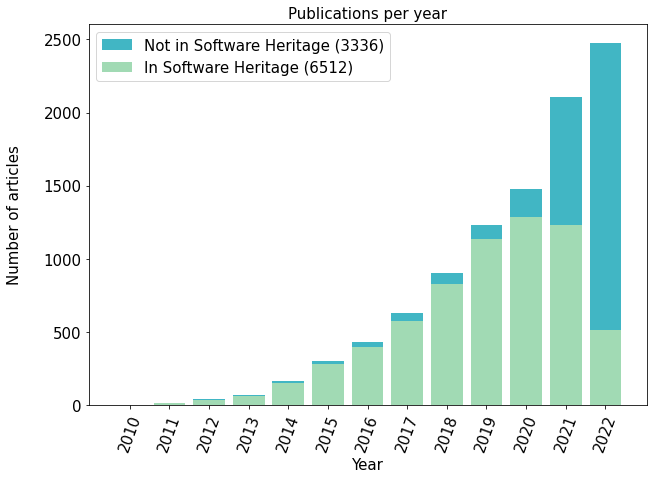

In [7]:
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(figsize=(10, 7))

with open("../data/stats_github.json", "r") as f:
    stats_github = json.load(f)

years = list(stats_github.keys())[1:]
values = list(stats_github.values())[1:]

#ax.bar(years, values, color='#225ea8')
df_grouped = df.groupby([df['PubDate'].dt.year]).size().reset_index(name='count')
ax.bar(years, df_grouped['count'], color='#41b6c4')
df_grouped = df.groupby([df['PubDate'].dt.year, 'In_SoftWH']).size().reset_index(name='count')
df_softwh = df_grouped[df_grouped['In_SoftWH'] == 1]
ax.bar(years, df_softwh['count'], color='#a1dab4')
ax.set_xlabel('Year', fontsize=15, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=15, fontfamily='sans-serif')
ax.set_title('Publications per year', fontsize=15, fontfamily='sans-serif')

ax.legend([f"Not in Software Heritage ({sum(df_grouped['count']) - sum(df_softwh['count'])})", 
           f"In Software Heritage ({sum(df_softwh['count'])})"], fontsize=15)

plt.xticks(years, rotation=70)
ax.tick_params(axis='y', labelsize=15) 
ax.tick_params(axis='x', labelsize=15) 

plt.savefig("../data/images/stat_swh.png")
plt.show()

### Plot the timeline of software development (Fig.2)

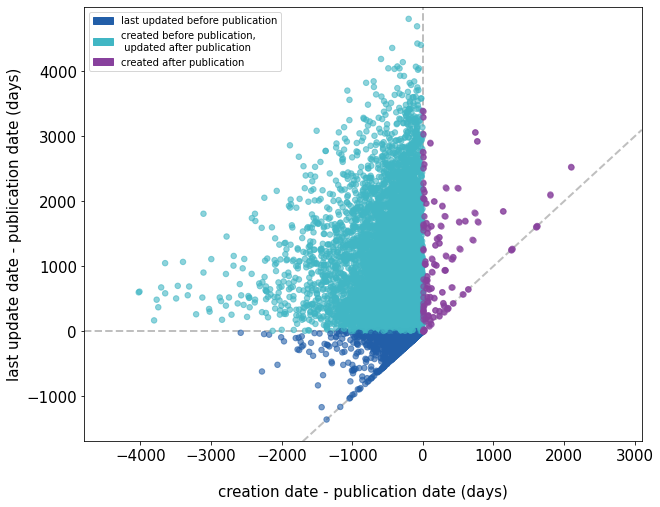

In [8]:
plt.rcParams['text.usetex'] = False
color = [0] * len(df)
alpha = [0] * len(df)

for index, row in enumerate(df["Days_before"]):
    if row < 0 and df["Days_after"].iloc[index] <= 0:
        color[index] = '#225ea8'
        alpha[index] = 0.6
    if row < 0 and df["Days_after"].iloc[index] > 0:
        color[index] = '#41b6c4'
        alpha[index] = 0.6
    if row >= 0:
        color[index] = '#88419d'
        alpha[index] = 0.6

fig, ax = plt.subplots(1, figsize=(10, 8))

ax.scatter(df['Days_before'], df['Days_after'], alpha = alpha, s = 30, color = color)
ax.scatter(df[df['Days_before']>=0]['Days_before'], df[df['Days_before']>=0]['Days_after'], alpha = 0.6, s = 30, color = '#88419d')

ax.axvline(x = 0, ymin = 0.26, ymax = 1, color = 'gray', linestyle = '--', linewidth = 2, alpha = 0.5, zorder = 0)  
ax.axhline(y = 0, xmin = 0, xmax = 0.6, color = 'gray', linestyle = '--', linewidth = 2, alpha = 0.5, zorder = 0)
ax.axline((0, 0),(1, 1), color = 'gray', linestyle = '--', linewidth = 2, alpha = 0.5, zorder = 0)

#ax.set_xlabel("\nrepository \\textbf{creation} date - publication date (days)", fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})
#ax.set_ylabel("repository last \\textbf{update} date - publication date (days)", fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})

ax.set_xlabel("\ncreation date - publication date (days)", fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})
ax.set_ylabel("last update date - publication date (days)", fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})

ax.set_xlim([-4800, 3100])
ax.set_ylim([-1700, 4999])

green_patch = mpatches.Patch(color='#88419d', label='created after publication')
lblue_patch = mpatches.Patch(color='#41b6c4', label='created before publication,\n updated after publication')
dblue_patch = mpatches.Patch(color='#225ea8', label='last updated before publication')
patches = [dblue_patch, lblue_patch, green_patch]
ax.legend(handles=patches, loc='upper left')
ax.tick_params(axis='y', labelsize=15) 
ax.tick_params(axis='x', labelsize=15) 

plt.savefig("../data/images/stat_dynam.png")
plt.show()

### Plot the quantification of the fig. 2 (Fig. 3)

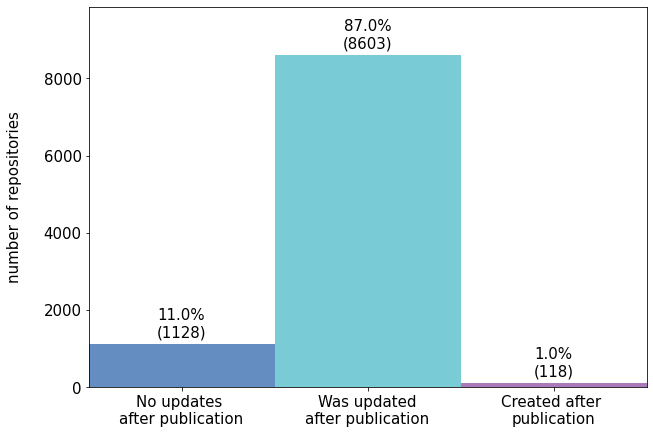

In [9]:
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(figsize=(10, 7))

after, no_update, update, forks = 0, 0, 0, 0
for index, row in df.iterrows():
    if row["Days_before"]>=0:
        after += 1 
    elif row["Days_before"]<0 and row["Days_after"]<0:
        no_update += 1
    elif row["Days_before"]<0 and row["Days_after"]>=0:
        update += 1
    if row["Fork"] == 1:
        forks += 1
n=0

data = [no_update, update, after]
bin_edges = [0.5, 1.5, 2.5]
labels = ['No updates \nafter publication', 'Was updated\nafter publication', 'Created after \npublication']
color=['#225ea8', '#41b6c4', '#88419d']
ax.bar(bin_edges[:], data, width=1, color=color, alpha = 0.7)
ax.set_xlim(0, 3)
#ax.set_yscale('log')
ax.set_xticks([0.5, 1.5, 2.5], labels, fontsize=15, fontfamily='sans-serif')


for i, datum in enumerate(data):
    ax.text(i+0.5, datum+100, f'{str(round(100*datum/sum(data),0))}%\n({str(datum)})', ha='center', va='bottom', fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})

ax.set_ylim([0, len(df)])
ax.set_ylabel('number of repositories\n', fontdict={'fontsize': 15, 'fontfamily': 'sans-serif'})
ax.tick_params(axis='y', labelsize=15) 

plt.savefig("../data/images/stat_hist.png")
plt.show()

### Plot the projections of the fig. 2 (Fig. 4 a-c)

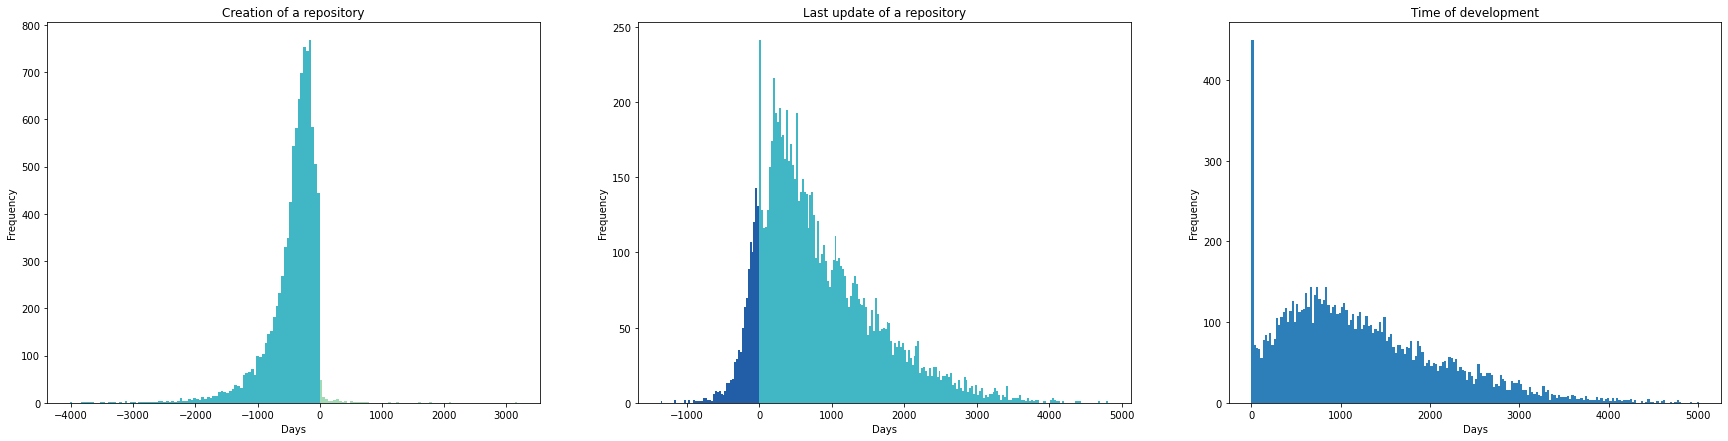

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

axs[0].hist(df[df['Days_before']>=0]['Days_before'], bins=round(40 / -min(df['Days_before']) * (max(df['Days_before'])-min(df['Days_before']))), color='#a1dab4')
axs[0].hist(df[df['Days_before']<0]['Days_before'], bins=round(40 / max(df['Days_before']) * (max(df['Days_before'])-min(df['Days_before']))), color='#41b6c4')
axs[1].hist(df[df['Days_after']>=0]['Days_after'], bins=round(40 / -min(df['Days_after']) * (max(df['Days_after'])-min(df['Days_after']))), color='#41b6c4')
axs[1].hist(df[df['Days_after']<0]['Days_after'], bins=round(40 / max(df['Days_after']) * (max(df['Days_after'])-min(df['Days_after']))), color='#225ea8')
axs[2].hist((df['Days_dev']), bins=200, color='#2c7fb8')

axs[0].set_xlabel('Days')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Creation of a repository')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Last update of a repository')
axs[2].set_xlabel('Days')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Time of development')

plt.savefig("../data/images/stat_dev.png")
plt.show()

### Plot the fig. 5b in a larger format (Fig. 5)

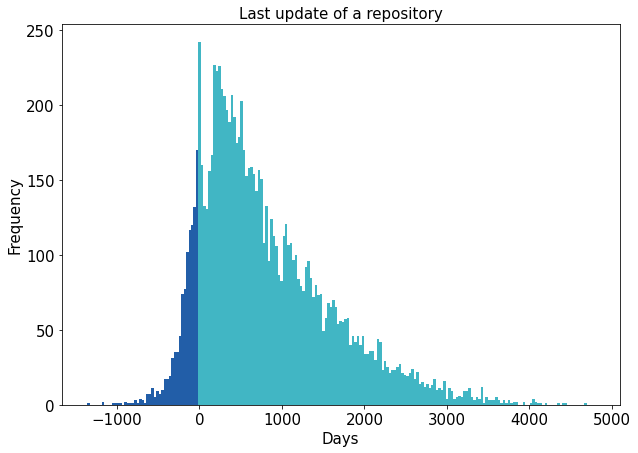

In [11]:
fig, axs = plt.subplots(figsize=(10, 7))

bin_size = 30
bin_edges = np.arange(min(df['Days_after']), max(df['Days_after']), bin_size)
axs.hist(df['Days_after'], bins = bin_edges, color='#41b6c4')

#bin_edges = np.arange(min(df[df['Days_after']>0]['Days_after']), max(df[df['Days_after']>0]['Days_after']), bin_size)
#axs.hist(df[df['Days_after']>0]['Days_after'], bins = bin_edges, color='#41b6c4', alpha=0.6)

bin_edges = np.arange(min(df[df['Days_after']<=0]['Days_after']), max(df[df['Days_after']<=0]['Days_after']), bin_size)
axs.hist(df[df['Days_after']<=0]['Days_after'], bins = bin_edges, color='#225ea8', )


axs.set_xlabel('Days', fontsize=15, fontfamily='sans-serif')
axs.set_ylabel('Frequency', fontsize=15, fontfamily='sans-serif')
axs.set_title('Last update of a repository',fontsize=15, fontfamily='sans-serif')
axs.tick_params(axis='y', labelsize=15) 
axs.tick_params(axis='x', labelsize=15) 

plt.savefig("../data/images/stat_last_updt.png")
plt.show()